In [61]:
from warnings import filterwarnings

filterwarnings("ignore")
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from crypto_momentum_portfolios.utility.data_loader import CryptoDataLoaderQIL
from crypto_momentum_portfolios.utility.types import (
    DataFrequency,
    Fields,
    RebalanceFrequency,
    Side,
    RankingMode,
    AllocationMethod,
    RankingMethod,
    AllocationMode,
    Benchmark,
)
from crypto_momentum_portfolios.portfolio_management.benchmarks import (
    BenchmarkDataFrameBuilder,
)
from crypto_momentum_portfolios.portfolio_management.backtester import (
    PortfolioBacktester,
)

dl = CryptoDataLoaderQIL()  # CryptoDataLoader()
dl.assets

Fetching symbols...: 100%|██████████| 21/21 [00:00<00:00, 52.91it/s]


['LTC-USDT',
 'DASH-USDT',
 'MATIC-USDT',
 'XLM-USDT',
 'ADA-USDT',
 'LINK-USDT',
 'BTC-USDT',
 'XRP-USDT',
 'AVAX-USDT',
 'VET-USDT',
 'KDA-USDT',
 'ETC-USDT',
 'EOS-USDT',
 'XTZ-USDT',
 'ATOM-USDT',
 'SOL-USDT',
 'DOGE-USDT',
 'ETH-USDT',
 'BCH-USDT',
 'TRX-USDT',
 'BNB-USDT']

In [63]:
DURATION_DAYS = 15 # Days
DURATION_MONTHS = 1 # Months

universe = (
    dl.get_crypto(
        "all",
        data_frequency=DataFrequency.DAILY,
        fields=[
            Fields.PRICE,
            Fields.MARKET_CAP,
            Fields.MOMENTUM,
            Fields.EMA_MOMENTUM,
            Fields.TS_MOMENTUM,
            Fields.VOLATILITY_NEUTRALIZED_MOMENTUM,
            Fields.RETURNS,
            Fields.VOLATILITY,
            Fields.VOLUME,
        ],
        flatten_fields_with_crypto=False,
        momentum_lookback=DURATION_DAYS * DURATION_MONTHS,
        ts_momentum_lookback=DURATION_DAYS * DURATION_MONTHS,
        ema_momentum_lookback=DURATION_DAYS * DURATION_MONTHS,
        volatility_lookback=DURATION_DAYS * DURATION_MONTHS,
    )
    .dropna()
    .loc[:]  # "2021-10-28"
)
universe.head()

price                                                     \
           LTC-USDT DASH-USDT MATIC-USDT  XLM-USDT  ADA-USDT LINK-USDT   
Date                                                                     
2021-08-20  183.542    232.64     1.5495  0.384759  2.456469   28.6642   
2021-08-21  179.637    237.43     1.5826  0.371399  2.435837   27.8456   
2021-08-22  185.867    254.91     1.6221  0.372481  2.697400   28.0020   
2021-08-23  187.123    270.46     1.6236  0.378449  2.917943   28.5754   
2021-08-24  173.500    248.24     1.4749  0.350552  2.718520   25.7346   

                                                  ...        volume  \
           BTC-USDT XRP-USDT AVAX-USDT  VET-USDT  ...      ETC-USDT   
Date                                              ...                 
2021-08-20  49319.4  1.26231    39.089  0.132982  ...  3.390266e+06   
2021-08-21  48821.3  1.21615    43.743  0.128139  ...  1.603774e+06   
2021-08-22  49237.4  1.22556    43.693  0.128070  ...  1.203882e+06   
2021-08-23  49478.2  1.24577    46.464  0.131778  ...  1.916332e+06   
2021-08-24  47662.5  1.13530    55.594  0.121224  ...  2.165215e+06   

                                                                    \
                EOS-USDT      XTZ-USDT     ATOM-USDT      SOL-USDT   
Date                                                                 
2021-08-20  9.800429e+06  2.279527e+06  1.196166e+07  7.030809e+06   
2021-08-21  1.271771e+07  2.038234e+06  2.337334e+07  6.002406e+06   
2021-08-22  9.707505e+06  1.213386e+06  1.709449e+07  4.272580e+06   
2021-08-23  1.248125e+07  4.661734e+06  8.541208e+06  4.506753e+06   
2021-08-24  1.580081e+07  4.927179e+06  9.913253e+06  8.591396e+06   

                                                                    \
               DOGE-USDT      ETH-USDT      BCH-USDT      TRX-USDT   
Date                                                                 
2021-08-20  4.546545e+07  2.472924e+08  4.450708e+06  5.480434e+06   
2021-08-21  3.578262e+07  2.020452e+08  2.700150e+06  4.019725e+06   
2021-08-22  2.793087e+07  1.777273e+08  2.649361e+06  3.339041e+06   
2021-08-23  3.208895e+07  2.488395e+08  4.774730e+06  5.466912e+06   
2021-08-24  3.324943e+07  2.603068e+08  3.122268e+06  5.171742e+06   

                          
                BNB-USDT  
Date                      
2021-08-20  2.399767e+07  
2021-08-21  2.098535e+07  
2021-08-22  1.541437e+07  
2021-08-23  3.693470e+07  
2021-08-24  2.599192e+07  

[5 rows x 189 columns]

# Building a benchmark


## Capitalization weighted index


In [64]:
benchmarks = (
    BenchmarkDataFrameBuilder(universe)
    .build_equally_weighted_benchmark(
        rebalance_frequency=RebalanceFrequency.MONTHLY, side=Side.LONG, verbose=False
    )
    .build_capitalization_weighted_benchmark(
        capitalization_field=Fields.MARKET_CAP,
        rebalance_frequency=RebalanceFrequency.MONTHLY,
        side=Side.LONG,
        verbose=False,
    )
    .build_bitcoin_benchmark()
    .collect_benchmark_returns()
)
benchmarks

,equal_weighted_benchmark,capi_weighted_benchmark,bitcoin_benchmark
Date,,,
2021-08-20,0.038999,0.017015,0.054606
2021-08-21,-0.007456,-0.013480,-0.010099
2021-08-22,0.012784,0.021181,0.008523
2021-08-23,0.033471,0.028170,0.004891
2021-08-24,-0.056437,-0.053573,-0.036697
...,...,...,...
2024-01-03,-0.077751,-0.063036,-0.046722
2024-01-04,-0.000750,0.000177,0.000735
2024-01-05,0.004782,0.019269,0.027073


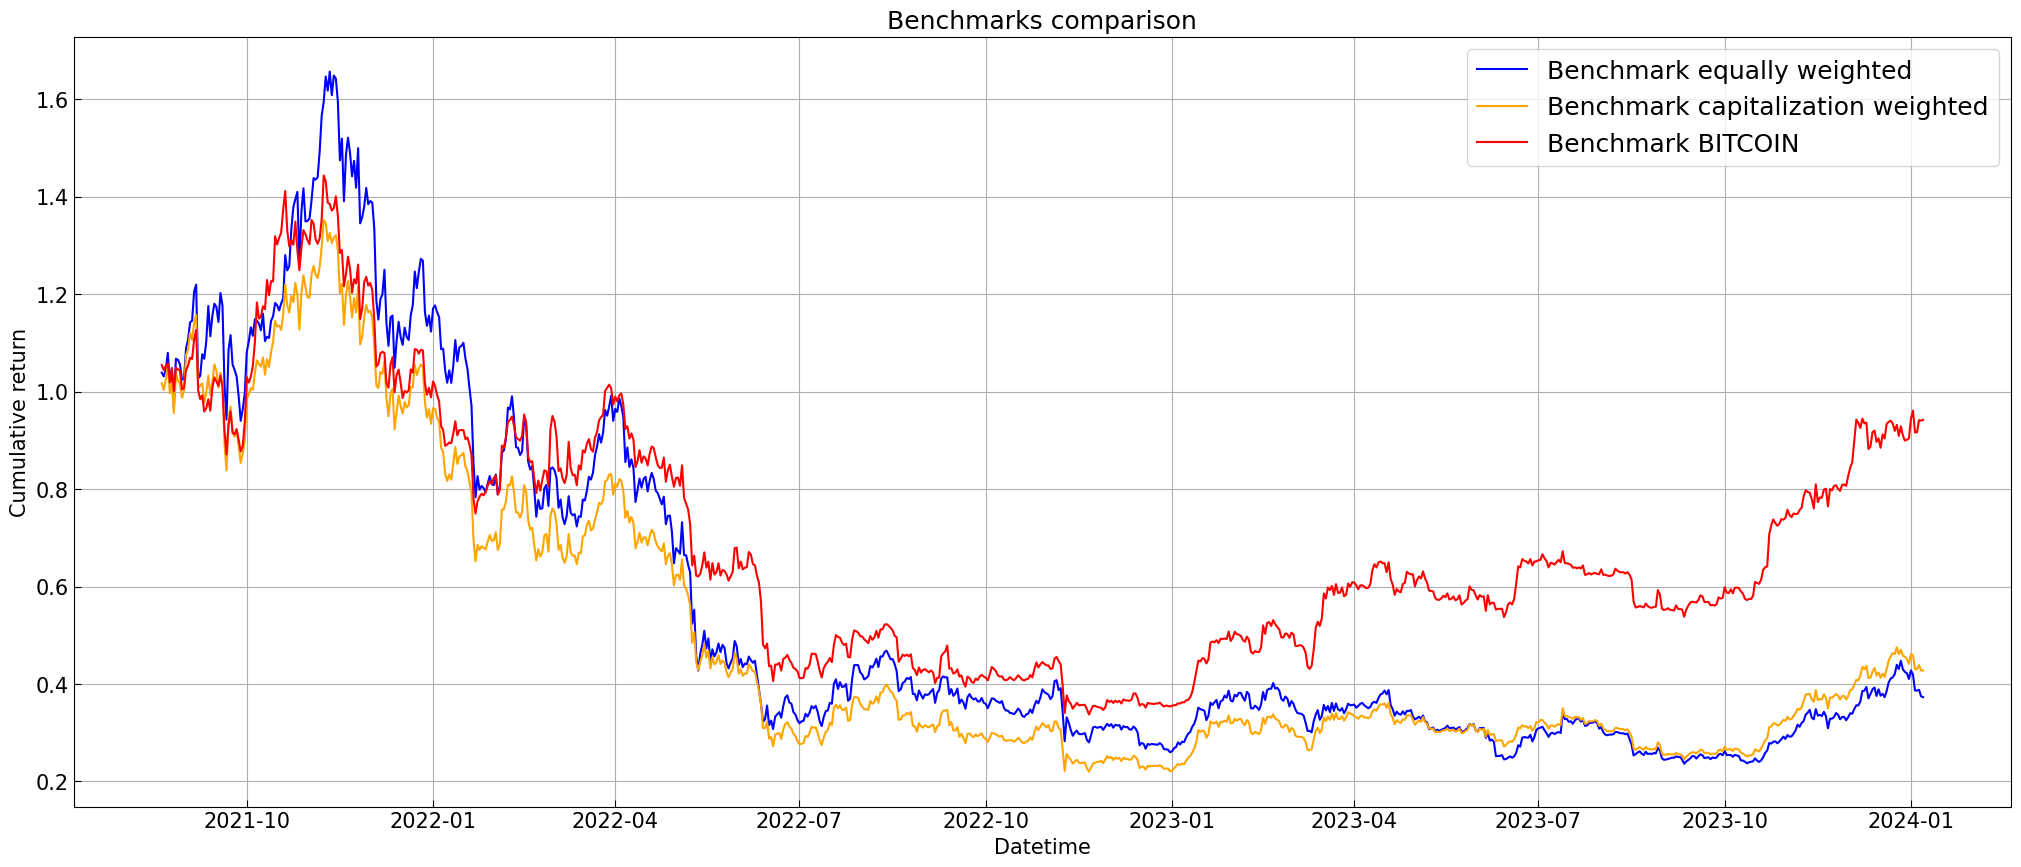

In [65]:
fsize = 15
tsize = 18
tdir = "in"
major = 5.0
minor = 3.0
lwidth = 0.8
lhandle = 2.0
plt.style.use("default")
# plt.rcParams['text.usetex'] = True
plt.rcParams["font.size"] = fsize
plt.rcParams["legend.fontsize"] = tsize
plt.rcParams["xtick.direction"] = tdir
plt.rcParams["ytick.direction"] = tdir
plt.rcParams["xtick.major.size"] = major
plt.rcParams["xtick.minor.size"] = minor
plt.rcParams["ytick.major.size"] = 5.0
plt.rcParams["ytick.minor.size"] = 3.0
plt.rcParams["axes.linewidth"] = lwidth
plt.rcParams["legend.handlelength"] = lhandle

f, ax = plt.subplots(1, 1, figsize=(25, 10))
ax.set_title("Benchmarks comparison", fontsize=18)
ax.grid()
ax.plot(
    (benchmarks["equal_weighted_benchmark"] + 1).cumprod(),
    label="Benchmark equally weighted",
    color="blue",
)
ax.plot(
    (benchmarks["capi_weighted_benchmark"] + 1).cumprod(),
    label="Benchmark capitalization weighted",
    color="orange",
)
ax.plot(
    (benchmarks["bitcoin_benchmark"] + 1).cumprod(),
    label="Benchmark BITCOIN",
    color="red",
)


ax.set_xlabel(
    "Datetime",
)
ax.set_ylabel(
    "Cumulative return",
)
ax.legend(
    loc="upper right",
)
# ax.set_yscale("log")

# Backtesting strategies
## Backtesting with a benchmark and a strategy


In [66]:
ptf_backtester = PortfolioBacktester(universe=universe, benchmarks=benchmarks)

returns, weights = ptf_backtester.run_strategy(
    ranking_method=RankingMethod.EMA_MOMENTUM,
    ranking_mode=RankingMode.DESCENDING,
    select_top_k_assets=3,
    allocation_method=AllocationMethod.MEAN_VARIANCE,
    allocation_mode=AllocationMode.CLASSIC,
    rebalance_frequency=RebalanceFrequency.EVERY_TWO_DAYS,
    side=Side.LONG,
    benchmark=Benchmark.BITCOIN,
    verbose=False,
    print_stats=True,
    plot_curve=True,
    perform_t_stats=True,
)


-----------------Expected return------------------
Benchmark: 13.74% vs Strategy: 411.19%

t-stat: 20.56, p-value: 0.00
Statistically different from the bench

-----------------------CAGR-----------------------
Benchmark: -4.61% vs Strategy: 2857.62%

t-stat: 2.59, p-value: 0.01
Statistically different from the bench

---------------Expected volatility----------------
Benchmark: 56.87% vs Strategy: 115.31%

t-stat: 38.06, p-value: 0.00
Statistically different from the bench

---------------------Skewness---------------------
Benchmark: -0.15 vs Strategy: 1.17

t-stat: 12.62, p-value: 0.00
Statistically different from the bench

---------------------Kurtosis---------------------
Benchmark: 3.79 vs Strategy: 7.33

t-stat: 4.51, p-value: 0.00
Statistically different from the bench

-----------------------VaR------------------------
Benchmark: -4.70% vs Strategy: -7.79%

t-stat: -18.04, p-value: 0.00
Statistically different from the bench

-----------------------CVaR----------------------

Loading BokehJS ...

Loading BokehJS ...

## Several strategies


In [6]:
# ptf_backtester = PortfolioBacktester(universe=universe)

# returns_capi, _ = ptf_backtester.run_strategy(
#     allocation_method=AllocationMethod.CAPITALIZATION_WEIGHTED,
#     rebalance_frequency=RebalanceFrequency.MONTHLY,
#     side=Side.LONG,
#     verbose=False,
#     print_stats=False,
#     plot_curve=False,
# )
# returns_capi.name = "capitalization_weighted"

# returns_rp, _ = ptf_backtester.run_strategy(
#     allocation_method=AllocationMethod.RISK_PARITY,
#     rebalance_frequency=RebalanceFrequency.MONTHLY,
#     side=Side.LONG,
#     verbose=False,
#     print_stats=False,
#     plot_curve=False,
# )
# returns_rp.name = "risk_parity"
# returns_mv, _ = ptf_backtester.run_strategy(
#     allocation_method=AllocationMethod.MEAN_VARIANCE,
#     rebalance_frequency=RebalanceFrequency.MONTHLY,
#     side=Side.LONG,
#     verbose=False,
#     print_stats=False,
#     plot_curve=False,
# )
# returns_mv.name = "mean_variance"
# returns, weights_df = ptf_backtester.run_strategy(
#     allocation_method=AllocationMethod.EQUAL_WEIGHTED,
#     rebalance_frequency=RebalanceFrequency.MONTHLY,
#     side=Side.LONG,
#     verbose=False,
#     print_stats=False,
#     plot_curve=False,
# )
# returns.name = "equal_weighted"

In [7]:
# returns_df = pd.concat([returns, returns_capi, returns_rp, returns_mv], axis=1)
# returns_df

### Plot all strategies


In [8]:
# ax = (returns_df + 1).cumprod().plot(figsize=(25, 10), grid=True)

# ax.set_title(
#     "Backtest track of the 24 days momentum strategy with montly rebalance", fontsize=18
# )

# ax.plot(
#     (benchmarks["capi_weighted_benchmark"] + 1).cumprod(),
#     label="capi_weighted_benchmark",
#     color="black",
# )
# ax.set_xlabel("Datetime", fontsize=15)
# ax.set_ylabel("Cumulative return", fontsize=15)
# ax.legend(loc="upper left")
# # ax.set_yscale("log")

### Plot one strategy


In [9]:
# f, ax = plt.subplots(1, 1, figsize=(25, 10))

# ax.set_title(
#     "Backtest track of the 24 days momentum strategy with montly rebalance", fontsize=18
# )
# ax.plot(
#     (returns_df["mean_variance"] + 1).cumprod(),
#     label="Stretegy",
#     color="blue",
# )

# ax.plot(
#     (benchmarks["capi_weighted_benchmark"] + 1).cumprod(),
#     label="capi_weighted_benchmark",
#     color="orange",
# )
# ax.set_xlabel("Datetime", fontsize=15)
# ax.set_ylabel("Cumulative return", fontsize=15)
# ax.legend(loc="upper left")
# # ax.set_yscale("log")

# ax.grid()